# Orbitas Schwarzschild

Partimos de la ecuación de energía que hemos obtenido analizando la métrica de Schwarzschild


$$
\frac{1}{2} \left( \frac{dr}{d \tau}\right)^2+ V (r) =E, 
$$

donde $E=\mathcal{E}^2/(2 \,c^2)$ y el potencial está dado por

$$
V(r)= -\frac{1}{2} \epsilon+ \epsilon \frac{GM}{c^2r} + \frac{L^2}{2 r^2}- \frac{GML^2}{c^2r^3}.
$$


In [3]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from scipy.special import ellipkinc
from scipy.special import ellipj
from scipy.integrate import solve_ivp
from scipy import optimize

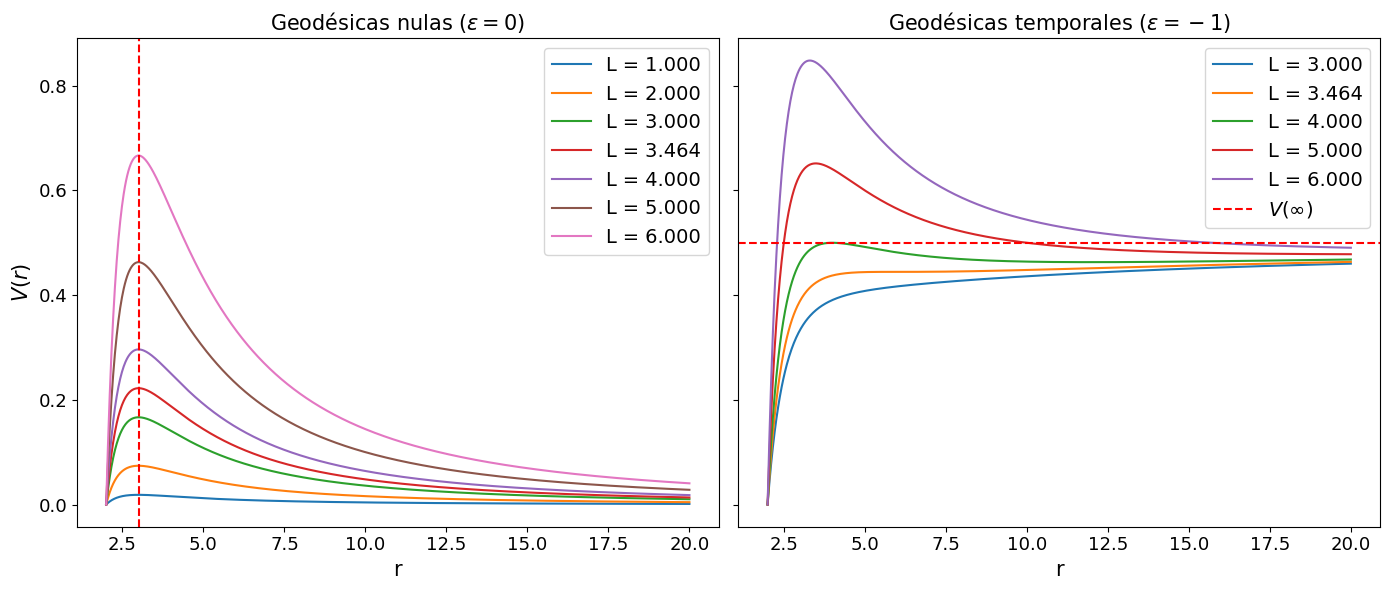

In [125]:
# Constantes
GM = 1
r = np.linspace(2, 20, 1000)  # Evitamos r=0 para evitar división por cero

# Potencial efectivo para geodésicas nulas (epsilon = 0)
def V_eff_null(r, L):
    return (L**2) / (2 * r**2) - GM * L**2 / (r**3)

# Potencial efectivo para geodésicas temporales (epsilon = -1)
def V_eff_timelike(r, L):
    return +0.5 - GM / r + (L**2) / (2 * r**2) - GM * L**2 / (r**3)

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)


# ----------- Geodésicas NULAS ---------------
L_values_null = [1, 2, 3, 2* np.sqrt(3), 4, 5, 6]
#colors = ['blue', 'red', 'green']
#linestyles = ['-', '--', '-.',':']

axs[0].set_title("Geodésicas nulas ($\epsilon=0$)", size=15)
axs[0].set_xlabel("r", size=15)
axs[0].set_ylabel("$V(r)$", size=15)
#axs[0].grid(True)

for L in L_values_null: #for L, style in zip(L_values_null, linestyles)
    V = V_eff_null(r, L)
    axs[0].plot(r, V, label=f"L = {L:.3f}") #, color="blue", linestyle=style

axs[0].legend(fontsize=14)
axs[0].tick_params(axis='x', labelsize=13)
axs[0].tick_params(axis='y', labelsize=13)
axs[0].axvline(x=3, color='red', linestyle='--', linewidth=1.5, label=r"$r = 3GM$")


# ----------- Geodésicas TEMPORALES ---------------
L_values_timelike = [3, 2* np.sqrt(3), 4, 5, 6]
#linestyles = ['-', '--', '-.',':']

axs[1].set_title("Geodésicas temporales ($\\epsilon=-1$)", size=15)
axs[1].set_xlabel("r", size=15)
#axs[1].grid(True)

for L  in L_values_timelike: #for L, style in zip(L_values_timelike, linestyles)
    V = V_eff_timelike(r, L)
    axs[1].plot(r, V, label=f"L = {L:.3f}") #, color="blue", linestyle=style

axs[1].axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label="$V(\\infty)$")
axs[1].tick_params(axis='x', labelsize=13)
axs[1].legend(fontsize=14)

plt.tight_layout()
plt.show()
#plt.savefig("../../Figuras/Potencial efectivo Schwarzchild")

plt.close()

Donde podemos indicar donde estan los másimos y los mínimos del potencial


\begin{equation}
    V'(r_\pm)=0 \implies- \epsilon \frac{GM}{c^2r_\pm^2} -\frac{L^2}{r_\pm^3}+ \frac{3GML^2}{c^2r_\pm^4}=0,
\end{equation}

Es decir,

\begin{equation}
    \left.V'(r)\right|_{r_\pm}=0 \implies \begin{cases}
        \displaystyle r_\pm=\frac{L^2 }{2GM}\left(1 \pm \sqrt{1-\frac{12 G^2M^2}{c^2L^2}}\right)  & \epsilon=-c^2\\
        \displaystyle r_\pm=r_c= \frac{3 GM}{c^2}& \epsilon=0
    \end{cases}.
\end{equation}


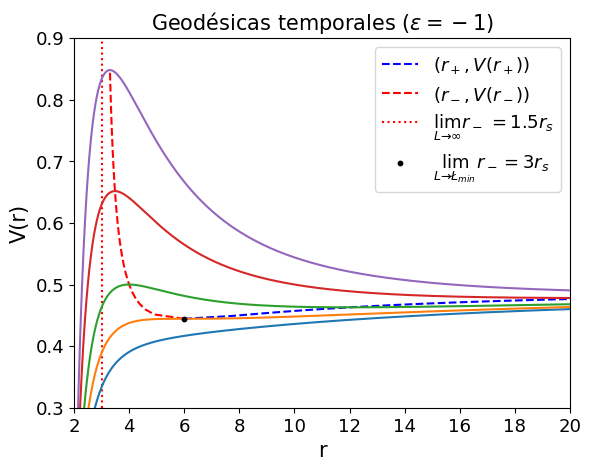

In [126]:
plt.title("Geodésicas temporales ($\\epsilon=-1$)", size=15)
plt.xlabel("r", size=15)
plt.ylabel("V(r)", size=15)

L_vals=np.linspace(2 * np.sqrt(3), L_values_timelike[-1], 30)

def r_minus(L):
    term1 = L**2-np.sqrt(L**4-12*GM**2*L**2)
    term2 = 2 *GM
    return term1/term2 

def r_plus(L):
    term1 = L**2+np.sqrt(L**4-12*GM**2*L**2)
    term2 = 2 *GM
    return term1/term2 

plt.plot(r_plus(L_vals), V_eff_timelike(r_plus(L_vals),L_vals), color="blue", linestyle="--", label="($r_+, V(r_+)$)")
plt.plot(r_minus(L_vals), V_eff_timelike(r_minus(L_vals),L_vals), color="red", linestyle="--", label="($r_-, V(r_-)$)")
plt.axvline(x=3, color='red', linestyle=':', linewidth=1.5, label="$\lim_{L\\to \\infty} r_- = 1.5 r_s$")
plt.scatter(6, 4/9, color='black', s=10, zorder=10, label="$\lim_{L\\to \\L_{min}} r_- = 3 r_s$")

for L  in L_values_timelike: #for L, style in zip(L_values_timelike, linestyles)
    V = V_eff_timelike(r, L)
    plt.plot(r, V) #label=f"L = {L:.3f}", color="blue", linestyle=style

plt.xlim(2, 20)
plt.ylim(0.3, 0.9)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)
plt.savefig("../../Figuras/Geodésicas_temporales.png")


A continuación, consideramos el sistema de ecuaciones que hemos obtenido en el trabajo para órbitas de schwarzschild

$$
\left\{\begin{aligned}
    \displaystyle \frac{dv}{d \tau}=&-\frac{d V}{dr}(r, \epsilon=0)\\
    \displaystyle \frac{dr}{d \tau}=&v\\
    \frac{d\phi}{d \tau}=&\frac{L}{r^2 \sin^2 \theta}
\end{aligned}\right. ,
$$

donde

$$
\frac{d V}{dr}(r, \epsilon)=-\epsilon \frac{GM}{c^2r^2}-\frac{L^2}{r^3}+\frac{3 GML^2}{c^2r^3}.
$$

Utilizamos en método de RK45 implementado por el módulo de python Scipy.



Ahora creamos un clase que nos ayudará a organizar el código donde incluiremos RK45 y el sistema que hemos mencionado con anterioridad. En él también introduciremos una función para la búsqueda de raíces 

$$\boxed{\frac{1}{b^2}=\frac{1}{r^2_{min}}-\frac{2GM}{c^2r_{min}^3}}$$

In [117]:

class Orbitas_Schwarzschild:
    def __init__(self, M=1.0, L=4.0, E=1.0, c=1.0, G=1.0):
        self.G = G
        self.c = c
        self.M = M
        self.L = L
        self.E = E
        self.rs = 2 * self.G * self.M / self.c**2
    
    def V(self, r, epsilon): #Potencial
        return (-0.5 * epsilon +
                epsilon * self.G * self.M / (self.c**2 * r) +
                self.L**2 / (2 * r**2) -
                self.G * self.M * self.L**2 / (self.c**2 * r**3))

    def dV_dr(self, r, epsilon): #Deribada del potencial
        return (-epsilon * self.G * self.M / (self.c**2 * r**2) -
                self.L**2 / r**3 +
                3 * self.G * self.M * self.L**2 / (self.c**2 * r**4))

    def system(self, tau, y, epsilon): #sistema de ecuaciones diferenciales de primer órden definidos anteriormente

        v, r,  phi= y
        dv_dtau = -self.dV_dr(r, epsilon)
        dphi_dtau = self.L / r**2

        return [dv_dtau, v, dphi_dtau]

    def stop_at_horizon(self, tau, y, epsilon): 
        r = y[0]
        return r - self.rs
    
    stop_at_horizon.terminal = True
    stop_at_horizon.direction = -1

    def solve(self, epsilon, r0=100.0, phi0=0.0, tau_span=(0, 200), max_step=0.1, N=400):
        # Resolver el sistema de ecuaciones diferenciales 
        v0 = -np.sqrt(np.maximum(self.E**2 - 2 * self.V(r0, epsilon), 0))  # Dirección inicial hacia adentro

        y0 = [v0, r0, phi0]

        sol = solve_ivp(
            fun=lambda tau, y: self.system(tau, y, epsilon),
            t_span=tau_span,
            y0=y0,
            events=lambda tau, y: self.stop_at_horizon(tau, y, epsilon),
            method='RK45',
            max_step=max_step,
            rtol=1e-9,
            atol=1e-9,
            #dense_output=True
            t_eval=np.linspace(*tau_span, N)
        )
        return sol
    
    #Analítico
    
    def rmin(self): #buscador de raíces del radio mínimo

        B= self.c * self.L/self.E

        def r(R, b):
            return 1 / b**2 - 1 / R**2 +  self.rs / R**3
        
        r_min= 3/2 * self.rs 
        r_max= 50 * self.rs
        
        fa = r(r_min, B)
        fb = r(r_max, B)

        if B<self.rs:
            rm_num = 0  # No hay raíz en este intervalo: descarta este rayo

        elif fa * fb > 0:
            fa = r(self.rs, B)
            fb = r(r_max, B)
            if fa * fb > 0:
                rm_num = self.rs
            else:
                sol = optimize.root_scalar(r, bracket=[r_min, r_max], args=(B,), method='brentq')
                rm_num = sol.root
        else:
            sol = optimize.root_scalar(r, bracket=[r_min, r_max], args=(B,), method='brentq')
            rm_num = sol.root
        return rm_num
    
    def geodesica(self, phi, phi_0=0.0):

        rs = self.rs

        B = self.L/self.E

        rmin=self.rmin()

        Q = np.sqrt((rmin-rs) * (rmin+ 3 * rs))

        k = np.sqrt((Q - rmin + 3 * rs) / (2 * Q))

        theta= 1/2*np.sqrt(Q/rmin) * (phi - phi_0)

        sn, _, _, _ = ellipj(theta, k)

        # Paso 4: calcular u(θ)
        term1 = (rmin - rs - Q) / (2 * rs * rmin)
        term2 = (Q - rmin + rs) / (2 * rs * rmin)

        u = term1 + term2 * sn**2

        return 1.0 / u

Nótese que la velocidad inicial se ha obtenido mediante la ecuación:

$$\frac{1}{2} \left( \frac{dr}{d \tau}\right)^2+ V (r) =E \implies \left. \frac{dr}{d \tau}\right|_{r=r_0} = V_0= -\sqrt{2 (E-V(r))} $$ 

donde $E=\mathcal{E}^2/(2 \,c^2)$, y se toma la raíz negativa para que el la velocidad inicial sea de caída hacia el agujero negro

Ahora hagamos un ejemplo para comprobar, tomamos el valor de $b=b_{lim}$ que en unidades geometrizadas $G=c=1$ y $M=1$ es 

$$ b = b_{lim}= \frac{3 \sqrt{3}}{2} r_s = 3 \sqrt{3} \approx 5.12618$$ 

(-12.151542381768383,
 105.34054963722707,
 -9.600614704576838,
 17.30123413728162)

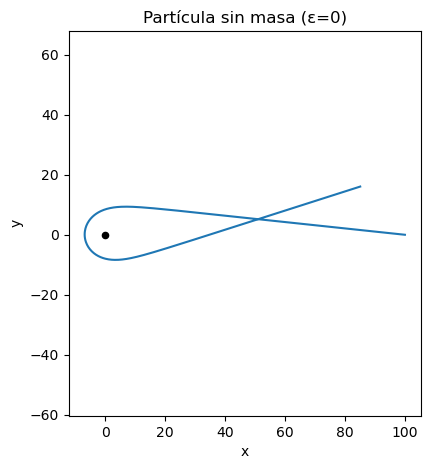

In [58]:
#Constantes
M=2.0
E=1.0
G=1.0
c=1.0
rs= 2 * G * M / c**2
L_light= 3*np.sqrt(3)/2 * rs * (1.02) #5.19618 #Loquito 2 vueltas 5.1962

tracer_massless = Orbitas_Schwarzschild(M=M,L=L_light, E=E)

sol_light = tracer_massless.solve(epsilon=0, max_step=0.01, tau_span=(0,200), N=1000)

# Coordenadas cartesianas
r  = sol_light.y[1]
phi= sol_light.y[2]

x_light = r * np.cos(phi)
y_light = r * np.sin(phi)

# ----------
# Plots
# ---------

plt.figure(figsize=(10, 5))

# Luz
plt.subplot(1, 2, 1)


plt.plot(x_light, y_light, label='Luz') #Trayectoria numérica

plt.scatter(0, 0, color='black', s=20, label='BH') #Agujero negro
plt.title("Partícula sin masa (ε=0)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")

Definimos una función que nos permita calcular el ángulo de deflexión a partir de la trayectoria. Para ello cogemos los 10 puntos inciales y finales. Realizamos una interpolación lineal y obtenemos la pendiente y el termino libre de ambas rectas.

Calculamos su intersección:

$$
\left.\begin{aligned}
    y&= ax+b\\
    y&= mx+n
\end{aligned} \right\} \implies \left(x=\frac{b-n}{m-a}, y = a \frac{b-n}{m-a}+b\right)
$$

Y apartir de aquí el ángulo viene dado por 

$$
\left.\begin{aligned}
    \alpha_i=\arctan \left(\frac{y_{light}[0]-y_c}{x_{light}[0]-x_c}\right)\\
    \alpha_f=\arctan \left(\frac{y_{light}[-1]-y_c}{x_{light}[-1]-x_c}\right)
\end{aligned} \right\} \implies \hat\alpha= \alpha_f-\alpha_i
$$

In [109]:
def deflexión_num(x_light, y_light):

    # Trayectoria inicial
    x_fit=x_light[0:9]
    y_fit=y_light[0:9]

    coeffs = np.polyfit(x_fit, y_fit, 1)  #y=ax+b
    a, b = coeffs

    # Trayectoria final

    x_fit=x_light[-10:]
    y_fit=y_light[-10:]

    coeffs = np.polyfit(x_fit, y_fit, 1) #y=mx+n
    m, n = coeffs

    #Punto en común:  ax+b=mx+n -> x=(n-b)/(a-m) 

    x_c=(n-b)/(a-m)
    y_c=a*(n-b)/(a-m)+b

    # Trayectoria origina

    x_line_1 = np.linspace(x_c-x_light[0]/10, x_light[0] , 100)
    y_line_1 = a * x_line_1 + b

    # Trayectoria final
    x_min= x_c-(x_light[-1]-x_c)/10
    x_line_2 = np.linspace(x_min, x_light[-1], 100)
    y_line_2 = m * x_line_2 + n

    #Angulo

    r=6*M

    beta_i=(np.arctan2(y_light[0]-y_c,x_light[0]-x_c)+np.pi) % (2 *np.pi)
    beta_f=(np.arctan2(y_light[-1]-y_c,x_light[-1]-x_c)) % (2 *np.pi)

    #Cálculo de la deflexión del ángulo

    alpha_num=(beta_f-beta_i) %(2 * np.pi)

    beta=np.linspace(beta_i,beta_f, 20)

    x_angulo=r * np.cos(beta)+ x_c
    y_angulo=r * np.sin(beta)+ y_c

    return beta_i, beta_f, alpha_num, x_angulo, y_angulo, x_c, y_c, x_line_1, y_line_1, x_line_2, y_line_2

Dibujemos algunas gráficas para ver si el ángulo que hemos calculado coincide con el de deflexión

Calculando trayectorias: 100%|██████████| 4/4 [00:10<00:00,  2.67s/trayectorias]


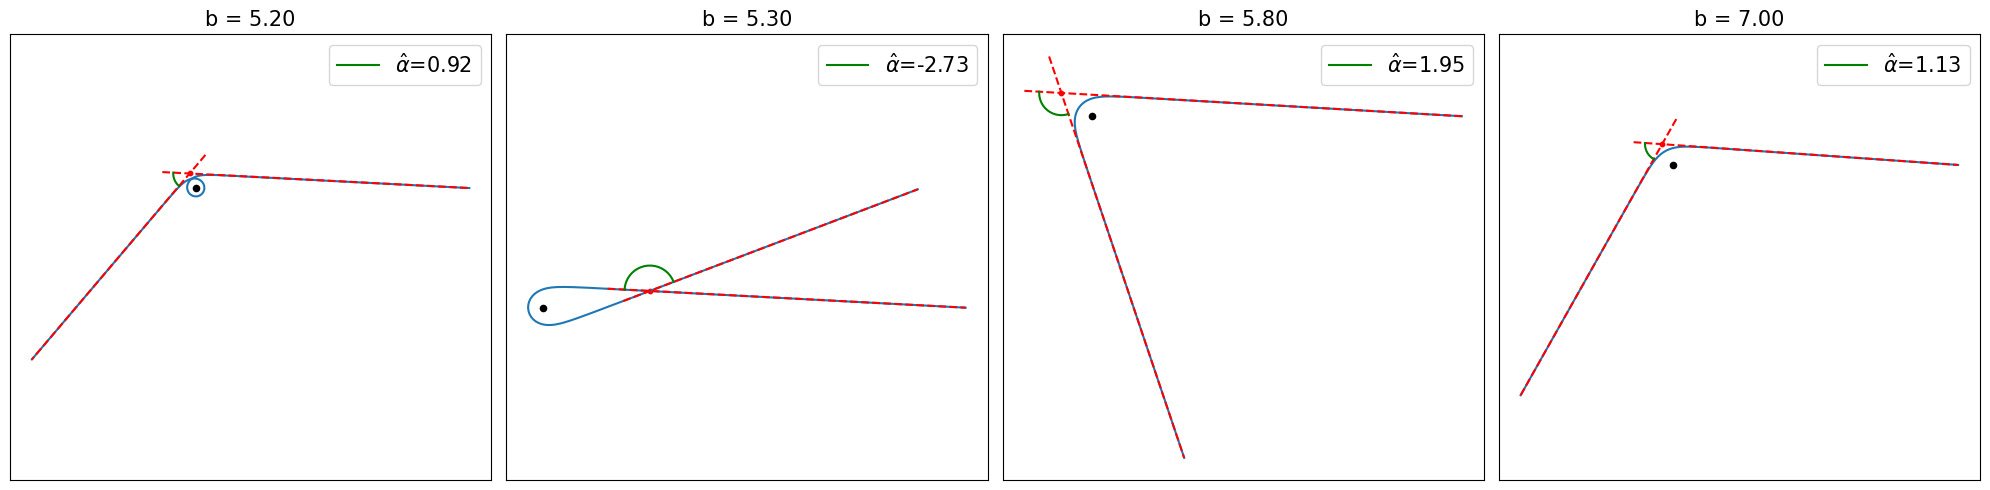

In [105]:
#Constantes
M=1.0
E=1.0
G=1.0
c=1.0
rs= 2 * G * M / c**2
L_list = [3 * np.sqrt(3) /2 * rs * (1.0005), 3 * np.sqrt(3) / 2 * rs * (1.02), 2.9 * rs, 3.5 * rs]
N = len(L_list)

# Crear figura con subplots
fig, axes = plt.subplots(1, N, figsize=(5*N, 5))  # 1 fila, N columnas

with tqdm(total=N, desc="Calculando trayectorias", unit="trayectorias") as pbar:
    for i, L in enumerate(L_list):
        tracer_massless = Orbitas_Schwarzschild(M=M, L=L, E=E, G=G, c=c)
        sol_light = tracer_massless.solve(epsilon=0, max_step=0.01, tau_span=(0, 200))

        x_light = sol_light.y[1] * np.cos(sol_light.y[2])
        y_light = sol_light.y[1] * np.sin(sol_light.y[2])

        #if sol_light.status == 0:
        beta_i, beta_f, alpha_num, x_angulo, y_angulo, x_c, y_c, x_line_1, y_line_1, x_line_2, y_line_2 = deflexión_num(x_light, y_light)

        rm = np.min(sol_light.y[1])
        B = L / E

            # Plot en el subplot correspondiente
        ax = axes[i]
        ax.plot(x_light, y_light) #, label='Luz'
        ax.plot(x_line_1, y_line_1, '--', color='red')
        ax.plot(x_line_2, y_line_2, '--', color='red')
        ax.scatter(x_c, y_c, color="red", s=10)
        ax.plot(x_angulo, y_angulo, color='green', label=f'$\\hat \\alpha$={alpha_num:.2f}')
            #ax.text(2 * r * np.cos(beta_i+alpha_num/2) + x_c, 2 * r * np.sin(beta_i+alpha_num/2) + y_c, f"$\\hat \\alpha$={alpha_num:.2f}", fontsize=15)

        ax.scatter(0, 0, color='black', s=20)
        ax.set_title(f"b = {B:.2f}", size=15)
        ax.legend(fontsize=15)
            #ax.set_xlabel("x")
            #ax.set_ylabel("y")
        ax.axis("equal")
        ax.set_xticks([])  # Quitar números del eje x
        ax.set_yticks([])  # Quitar números del eje y
            #ax.set_frame_on(False)  # Alternativa compacta: quita todos los spines
            # ax.grid(True)  # opcional

        pbar.update(1)

plt.tight_layout()
#plt.suptitle("Trayectorias para diferentes valores de L", fontsize=16, y=1.02)
#plt.show()
plt.savefig("../../Figuras/Trayectorias_y_deflexión.png")


Adicionalmente tambien podemos definir la función analítica de deflexión (Ref. Charles Darwin 1958) 

$$
\boxed{\hat\alpha=4 \sqrt{\frac{r_{min}}{Q}} F (\varphi_1, k)- \pi}, \quad \text{donde} \quad \varphi_1= \arcsin \left( \sqrt{\frac{2 Q}{3 r_{min}-3 r_s + Q}}\right)
$$

In [ ]:
#Deflexíon del ángulo teórico
def deflexion_analitica(rm):
    s=np.sqrt((rm-2*G*M/c**2)*(rm+2*G*M/c**2))
    m=(s-rm+6*M)/2/s
    arg=np.sqrt(2*s/(3*rm-6*G*M/c**2 +s))
    arg = np.clip(arg, -1.0, 1.0)
    varphi=np.arcsin(arg)
    alpha_teórico=(4*np.sqrt(rm/s)*float(ellipkinc(varphi, m)) - np.pi ) #% (2 * np.pi) #[0, π]

    return alpha_teórico

Comparemos ahora la deflexión analítica con la teórica

Calculando trayectorias: 100%|██████████| 100/100 [03:50<00:00,  2.30s/trayectorias]


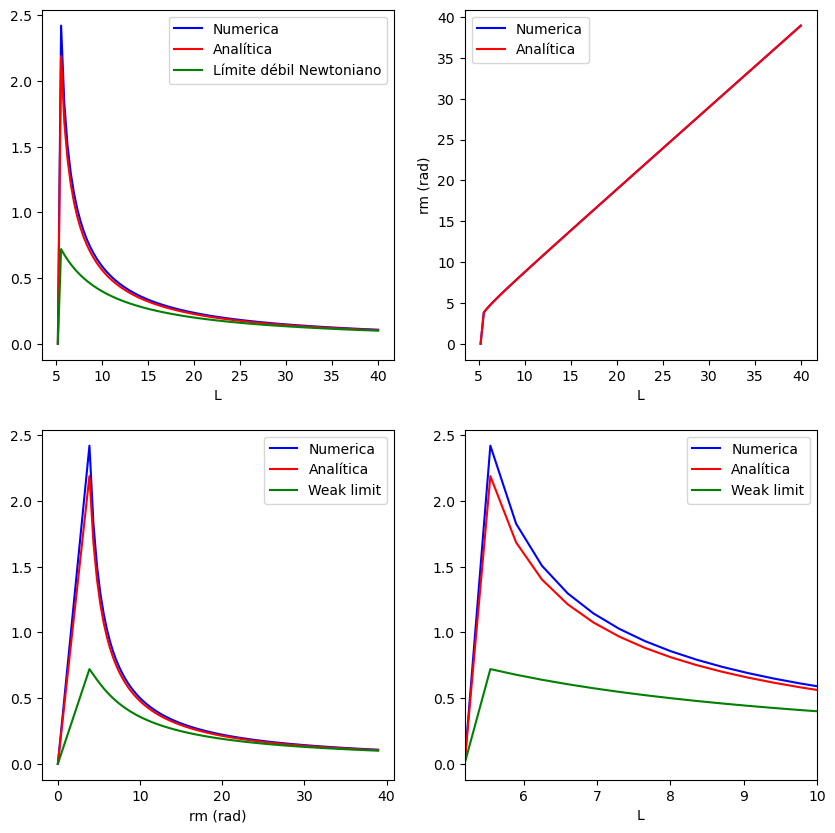

In [106]:
#Constantes
M=1.0
E=1.0
G=1.0
c=1.0
rs= 2 * G * M / c**2
L_light= 3*np.sqrt(3)/ 2 * rs  #5.196152423 #Loquito 2 vueltas 5.1962 #3*np.sqrt(3)


N=100
L_list=np.linspace(L_light, 40, N)

alpha_list=np.zeros(N)
alpha_num_list=np.zeros(N)
alpha_pm_list=np.zeros(N)
rm_list=np.zeros(N)
rm_num_list=np.zeros(N)

with tqdm(total=N, desc="Calculando trayectorias", unit="trayectorias") as pbar:

    for i in range(N):
        L=L_list[i]
        tracer_massless = Orbitas_Schwarzschild(M=M, L=L, E=E, G=G, c=c)

        # Resolver trayectorias
        sol_light = tracer_massless.solve(epsilon=0, max_step=0.02, tau_span=(0, 200), N=400)

        # Coordenadas cartesianas
        x_light = sol_light.y[1] * np.cos(sol_light.y[2])
        y_light = sol_light.y[1] * np.sin(sol_light.y[2])

    
        if sol_light.status==0:
            
            rm_num = np.min(sol_light.y[1])
            rm = tracer_massless.rmin()

            #print(rm,rm_num)
            rm_list[i]=rm
            rm_num_list[i]=rm_num

            #Deflexíon del ángulo teórico
            alpha_num = deflexión_num(x_light, y_light)[2]
            alpha_teórico = deflexion_analitica(rm)

            alpha_num_list[i]=alpha_num
            alpha_list[i]=alpha_teórico

            B=L/E
            xi=B 
            alpha_pm_list[i]=4.0*G*M/c**2/xi
        pbar.update(1)

# ----------
# Plots
# ---------

plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)

plt.plot(L_list, alpha_num_list, color="blue", label='Numerica') #Deflexión numérica
plt.plot(L_list, alpha_list, color="red", label='Analítica') #Trayectoria analítica
plt.plot(L_list, alpha_pm_list, color="green", label='Límite débil Newtoniano') #Trayectoria analítica
plt.xlabel("L")
#plt.ylabel("$ \hat \alpha $ (rad)")
plt.legend()

plt.subplot(2,2,2)

plt.plot(L_list, rm_num_list, color="blue", label='Numerica') #Deflexión numérica
plt.plot(L_list, rm_list, color="red", label='Analítica') #Trayectoria analítica
plt.xlabel("L")
plt.ylabel("rm (rad)")
plt.legend()

plt.subplot(2,2,3)

plt.plot(rm_num_list, alpha_num_list, color="blue", label='Numerica') #Deflexión numérica
plt.plot(rm_list, alpha_list, color="red", label='Analítica') #Trayectoria analítica
plt.plot(rm_list, alpha_pm_list, color="green", label='Weak limit') #Trayectoria analítica
plt.xlabel("rm (rad)")
#plt.ylabel("$ \hat \alpha $ (rad)")
plt.legend()

plt.subplot(2,2,4)

plt.plot(L_list, alpha_num_list, color="blue", label='Numerica') #Deflexión numérica
plt.plot(L_list, alpha_list, color="red", label='Analítica') #Trayectoria analítica
plt.plot(L_list, alpha_pm_list, color="green", label='Weak limit') #Trayectoria analítica
plt.xlim(L_list[0], 10)
plt.xlabel("L")
#plt.ylabel("$ \hat \alpha $ (rad)")
plt.legend()

plt.show()
plt.close()

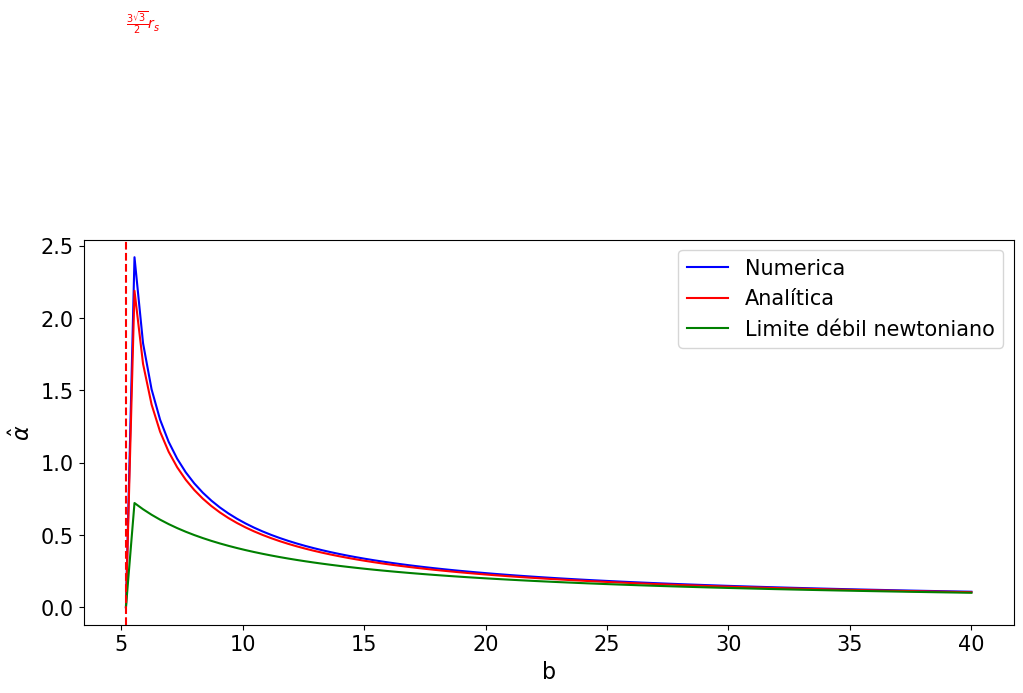

In [108]:
plt.figure(figsize=(12, 5))

plt.plot(L_list/E, alpha_num_list, color="blue", label='Numerica') #Deflexión numérica
plt.plot(L_list/E, alpha_list, color="red", label='Analítica') #Trayectoria analítica
plt.plot(L_list/E, alpha_pm_list, color="green", label='Limite débil newtoniano') #Trayectoria analítica
plt.xlabel("b", size=16)
plt.ylabel("$\hat\\alpha$", size=16)
plt.axvline(x=3 * np.sqrt(3) / 2 * rs, linestyle="--", color="red")
plt.text(3 * np.sqrt(3) /2 * rs, 4, "$\\frac{3 \sqrt{3}}{2} r_s$", color="red" )
#plt.ylabel("$ \hat \alpha $ (rad)")

plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("../../Figuras/Deflexión_del_ángulo.png")

Ahora dibujamos las órbitas de luz y su deflexión (en verde) además de las órbitas de partículas masivas.

0.4887059768888889
V_max= 0.0 c
-0.9986494957691613 3.2729455163647745


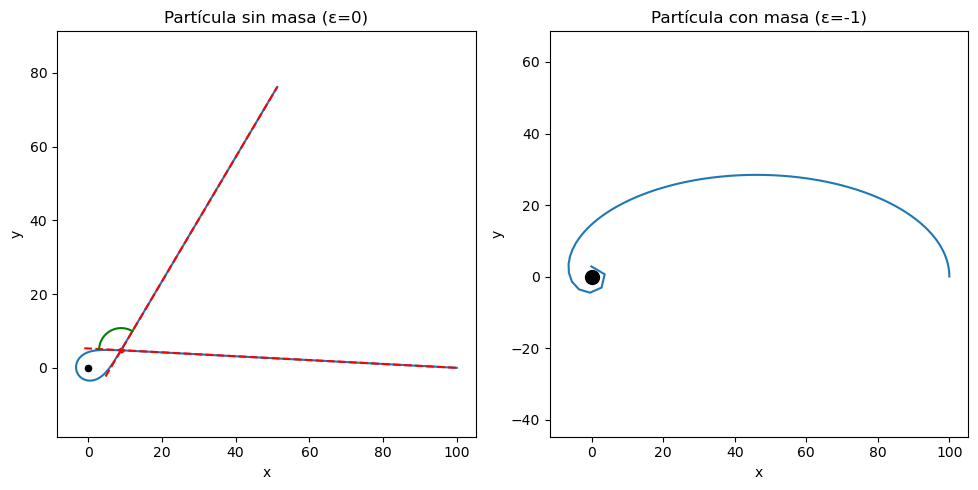

In [42]:
#Constantes
M=2.0
E=1.0
G=1.0
c=1.0
rs= 2 * G * M / c**2
L_light= 3*np.sqrt(3)/2 * rs * (1.01) #5.19618 

def V_timelike_geom_units(L,r):
    return (c**2/2  - rs*c**2 / (2 * r) + L**2 / (2 * r**2) - G * M * L**2 / (c**2 * r**3))

L_mass= np.sqrt(3) * rs * c * (1.12)
r0= 15 * rs

E_massive=V_timelike_geom_units(L_mass,r0)*(1.03)

print(E_massive)

tracer_massless = Orbitas_Schwarzschild(M=M,L=L_light, E=E)
tracer_massive = Orbitas_Schwarzschild(M=M, L=L_mass, E=E_massive)

# Resolver trayectorias
sol_light = tracer_massless.solve(epsilon=0, max_step=0.01, tau_span=(0,200), N=400)
sol_massive = tracer_massive.solve(epsilon=-1, max_step=0.01, tau_span=(0,2000), N=500)

# Coordenadas cartesianas
r  = sol_light.y[1]
phi= sol_light.y[2]

x_light = r * np.cos(phi)
y_light = r * np.sin(phi)

x_massive = sol_massive.y[1] * np.cos(sol_massive.y[2])
y_massive = sol_massive.y[1] * np.sin(sol_massive.y[2])
v_max = np.max(sol_massive.y[0])

print("V_max=", v_max, "c")

# ----------
# Plots
# ---------

plt.figure(figsize=(10, 5))

# Luz
plt.subplot(1, 2, 1)


plt.plot(x_light, y_light, label='Luz') #Trayectoria numérica

if sol_light.status==0:
    beta_i, beta_f, alpha_num, x_angulo, y_angulo, x_c, y_c, x_line_1, y_line_1, x_line_2, y_line_2=deflexión_num(x_light, y_light)
    
    plt.plot(x_line_1, y_line_1, '--', color='red') # Trayectoria original
    plt.plot(x_line_2, y_line_2, '--', color='red') # Trayectoria final

    plt.scatter(x_c, y_c, color="red", s=10) 
    plt.plot(x_angulo, y_angulo, color='green') # Ángulo de deflexión

plt.scatter(0, 0, color='black', s=20, label='BH') #Agujero negro


plt.title("Partícula sin masa (ε=0)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
#plt.grid(True)

# Masa
plt.subplot(1, 2, 2)
plt.plot(x_massive, y_massive, label='Masa')
plt.scatter(0, 0, color='black', s=100, label='BH')
plt.title("Partícula con masa (ε=-1)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
#plt.grid(True)

plt.tight_layout()
#plt.show()
plt.savefig("../../Figuras/Trayectorias.png")
#plt.close()

Ahora estudiémos las órbitas de luz más en profundidad:

## Orbitas de geodésicas nulas

$Radio mínimo: r_{min}=$ 0 0.5938785007092914
$Radio mínimo: r_{min}=$ 2.0 1.0587413349860852
$Radio mínimo: r_{min}=$ 2.0 1.3477272923224584
$Radio mínimo: r_{min}=$ 2.0 1.8103155166362916
$Radio mínimo: r_{min}=$ 2.0 1.3511354476430892
$Radio mínimo: r_{min}=$ 3.0 1.4356974179263724
$Deflexión del ángulo \hat \alpha=$ 0 nan
$Radio mínimo: r_{min}=$ 3.0 1.4356974179263724
$Deflexión del ángulo \hat \alpha=$ 0 nan
$Radio mínimo: r_{min}=$ 4.453363193811355 4.457224862169094
$Deflexión del ángulo \hat \alpha=$ 1.7193844505486862 1.5899877140701886
$Radio mínimo: r_{min}=$ 5.617279912116332 5.6210663734438455
$Deflexión del ángulo \hat \alpha=$ 1.1276331121021692 1.0600289896160575
$Radio mínimo: r_{min}=$ 6.7005234822665845 6.700547407492488
$Deflexión del ángulo \hat \alpha=$ 0.8587211735643789 0.8126815784156727


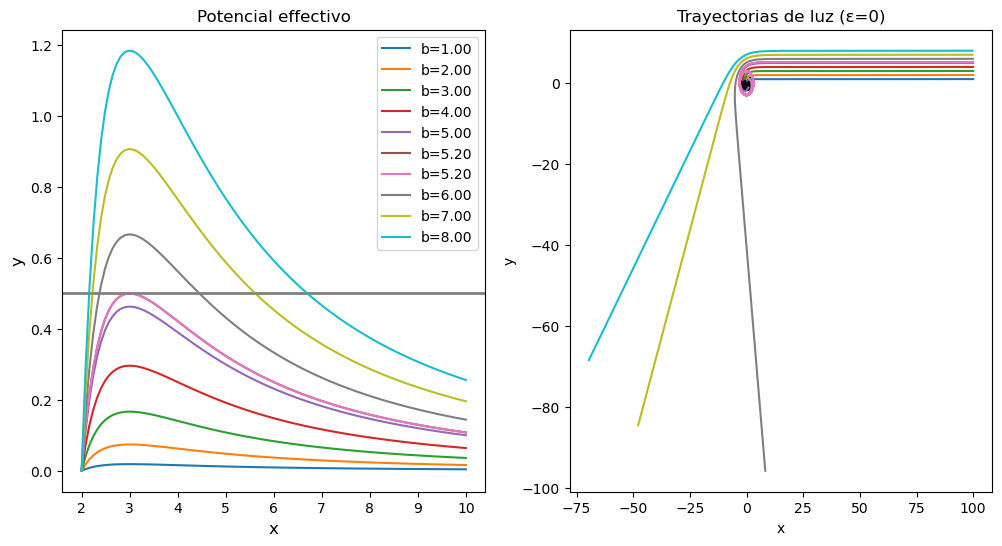

In [77]:
#Constantes
M=1.0
E=1.0
G=1.0
c=1.0
rs= 2 * G * M / c**2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

def V(r, L, M, epsilon):
    return (-c**2 / 2 * epsilon +
        epsilon * rs / 2 * c**2 +
        L**2 / (2 * r**2) -
        G * M * L**2 / (c**2 * r**3))

L_list=[1,2,3,4,5, 3* np.sqrt(3), 6,7,8]
L_list.append(L_light)
L_list.sort()
r= np.linspace(rs, 5 * rs, 100)

for L in L_list:
    tracer_massless = Orbitas_Schwarzschild(M=M,L=L, E=E, G=G, c=c)    
    sol_light = tracer_massless.solve(epsilon=0, phi0 = np.arcsin(L/100), max_step=0.1, tau_span=(0, 200))
    #print(len(sol_light.y[0]))

    # Coordenadas cartesianas
    x_light = sol_light.y[1] * np.cos(sol_light.y[2])
    y_light = sol_light.y[1] * np.sin(sol_light.y[2])

    ax2.plot(x_light, y_light, label='numérica')
    ax1.plot(r, tracer_massless.V(r, 0), label=f'b={L:.2f}')
    ax1.axhline(E**2/2, color='gray', lw=1)

    #Radio mínimo

    rm_num = np.min(sol_light.y[1])

    B=L/E

    rm= tracer_massless.rmin()

    print(r"$Radio mínimo: r_{min}=$", rm, rm_num)

    #Deflexión del ángulo numerico

    if sol_light.status==0:
        alpha_num=deflexión_num(x_light,y_light)[2]
    else: 
        alpha_num=0

    #Deflexíon del ángulo teórico
    if rm> tracer_massless.rs:
        alpha_teórico= deflexion_analitica(rm)

        print(r"$Deflexión del ángulo \\hat \\alpha=$", alpha_num, alpha_teórico)

ax1.legend(fontsize=10)
ax1.set_title("Potencial effectivo", fontsize=12)
ax1.set_xlabel("x", size=12)
ax1.set_ylabel("y", size=12)
ax2.scatter(0, 0, color='black', s=100, label='BH')
ax2.set_title("Trayectorias de luz (ε=0)", fontsize=12)
ax2.set_xlabel("x")
ax2.set_ylabel("y")

plt.show()
#plt.savefig("../../Figuras/Trayectorias_luz.png")
plt.close()

Renderizando: 100%|██████████| 40/40 [01:57<00:00,  2.95s/Tr]


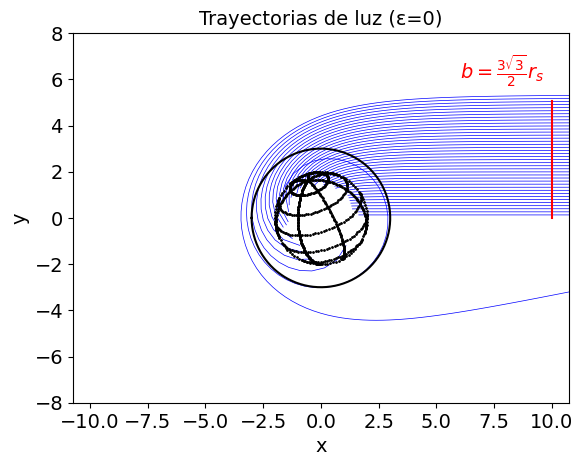

In [55]:
#Constantes
M=2.0
E=1.0
G=1.0
c=1.0
rs= 2 * G * M / c**2

L_light= 3 * np.sqrt(3) /2 * rs

L_list=np.linspace(L_light*0.025, L_light*1.025, 40)

x_min, x_max = -4 * rs, 4 * rs
y_min, y_max = -4 * rs, 4 * rs

from tqdm import tqdm

with tqdm(total=len(L_list), desc="Renderizando", unit="Tr") as pbar:
    for L in L_list:
        tracer_massless = Orbitas_Schwarzschild(M=M,L=L, E=E)
            
        sol_light = tracer_massless.solve(epsilon=0, phi0 = np.arcsin(L/100), max_step=0.01, tau_span=(20, 140), N=500)
            #print(len(sol_light.y[0]))

            # Coordenadas cartesianas
        x_light = sol_light.y[1] * np.cos(sol_light.y[2])
        y_light = sol_light.y[1] * np.sin(sol_light.y[2])

        # Crear máscara booleana: True si está dentro de ambos límites
        mask = (x_light >= x_min) & (x_light <= x_max*1.5) & \
                (y_light >= y_min) & (y_light <= y_max) & (x_light**2+y_light**2> rs)

        # Aplicar máscara
        x_light = x_light[mask]
        y_light = y_light[mask]

        plt.plot(x_light, y_light, label='numérica', zorder=1, color="blue", lw=0.5)

        pbar.update(1)


from Proyección_esfera import EsferaProyectada

plt.Circle((0,0), rs, color="white", fill=True, zorder=100)

esfera = EsferaProyectada(radius=rs)
proy = esfera.proyectar()

plt.scatter(proy[:, 0], proy[:, 1], s=1, color='black', zorder=2)


phi_circle = np.linspace(-np.pi, np.pi, 100)
plt.plot( 3 / 2 * rs * np.cos(phi_circle), 3 / 2 * rs * np.sin(phi_circle), color='black', zorder=2)

plt.plot(np.array([10, 10]),np.array([0.0, 3* np.sqrt(3)/2*rs*0.97]), color="red")
plt.text(6,6, "$ b= \\frac{3 \sqrt{3}}{2} r_s$", color="red", fontsize=14)
plt.title("Trayectorias de luz (ε=0)", size=14)
plt.xlabel("x", size=14)
plt.ylabel("y", size=14)
plt.axis("equal")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.show()
plt.savefig("../../Figuras/Trayectorias_luz_2.png")

## Órbitas de partículas masívas

In [ ]:
from tqdm import tqdm

#Constantes
M=1.0
E=1.0
G=1.0
c=1.0
rs= 2 * G * M / c**2

#Funciones
def V_timelike_geom_units(L,r):
    return (0.5  - 1 / r + L**2 / (2 * r**2) -L**2 / (r**3))

def r_minus(L):
    return L**2/(2*M)*(1-np.sqrt(1- (3 * (2*M)**2)/L**2))

def r_plus(L):
    return L**2/(2*M)*(1+np.sqrt(1- (3 * (2*M)**2)/L**2))

def V_r_c(L, rmin):
    return 0.5 - 2/3 * M / rmin + 1/6 * L**2 /rmin**2

def r0max_root(r, L):
    return V_timelike_geom_units(L,r)-V_timelike_geom_units(L,r_minus(L))

def rmax(r, E, L):
    return E-V_timelike_geom_units(L,r)


#L_light=10

def orbitas_masa(L_mass, h=0, E=None):

    if (L_mass>= rs * c * np.sqrt(3)) and (L_mass<= 2 * rs * c): 
        #h= np.random.rand()/15+1/6
        #print(h)
        E_massive=V_r_c(L_mass, r_minus(L_mass))-(V_r_c(L_mass, r_minus(L_mass))-V_r_c(L_mass, r_plus(L_mass)))*h
        sol = optimize.root_scalar(rmax, bracket=[r_plus(L_mass), 1000*rs], args=(E_massive, L_mass,), method='brentq')
        r_max=sol.root
        sol = optimize.root_scalar(rmax, bracket=[r_minus(L_mass), r_plus(L_mass)], args=(E_massive, L_mass,), method='brentq')
        r_min=sol.root
        tracer_massive = Orbitas_Schwarzschild(M=M, L=L_mass, E=E_massive, G=G, c=c)
        estilo="--"
        sol_massive = tracer_massive.solve(epsilon=-1, r0=r_max,  tau_span=(0, 10000), N=1000) 
    
    elif (L_mass > 2 *rs * c): 
        r_max=30*M * L_mass/(5 *M)
        if E==None:
            E_massive=V_timelike_geom_units(L_mass,r_max)*1.000003
            sol = optimize.root_scalar(rmax, bracket=[r_minus(L_mass), r_plus(L_mass)], args=(E_massive, L_mass,), method='brentq')
            r_min=sol.root
            tracer_massive = Orbitas_Schwarzschild(M=M, L=L_mass, E=E_massive, G=G, c=c)
            estilo="-"
        else:
            E_massive=E
            sol = optimize.root_scalar(rmax, bracket=[r_plus(L_mass), 1000*rs], args=(E_massive, L_mass,), method='brentq')
            r_max=sol.root
            sol = optimize.root_scalar(rmax, bracket=[r_minus(L_mass), r_plus(L_mass)], args=(E_massive, L_mass,), method='brentq')
            r_min=sol.root
        tracer_massive = Orbitas_Schwarzschild(M=M, L=L_mass, E=E_massive, G=G, c=c)
        estilo="-"
        sol_massive = tracer_massive.solve(epsilon=-1, r0=r_max,  tau_span=(0, 100000), N=1000) 
        print(len(sol_massive.y[1]))
    else:
        r_min=2 *M
        r_max=10
        E_massive=V_timelike_geom_units(L_mass,r_max)
        tracer_massive = Orbitas_Schwarzschild(M=M, L=L_mass, E=E_massive, G=G, c=c)
        estilo=":"
        sol_massive = tracer_massive.solve(epsilon=-1, r0=r_max, max_step=0.001, tau_span=(0, 2000), N=500) 

    x_massive = sol_massive.y[1] * np.cos(sol_massive.y[2])
    y_massive = sol_massive.y[1] * np.sin(sol_massive.y[2])
    r_min = np.min(sol_massive.y[1])
    r_max = np.max(sol_massive.y[1])
    #v_max = np.max(sol_massive.y[0])
    return x_massive, y_massive, estilo, r_max, r_min, E_massive
    #print("V_max=", v_max, "c")


Renderizando: 100%|██████████| 6/6 [02:30<00:00, 25.01s/Tr]


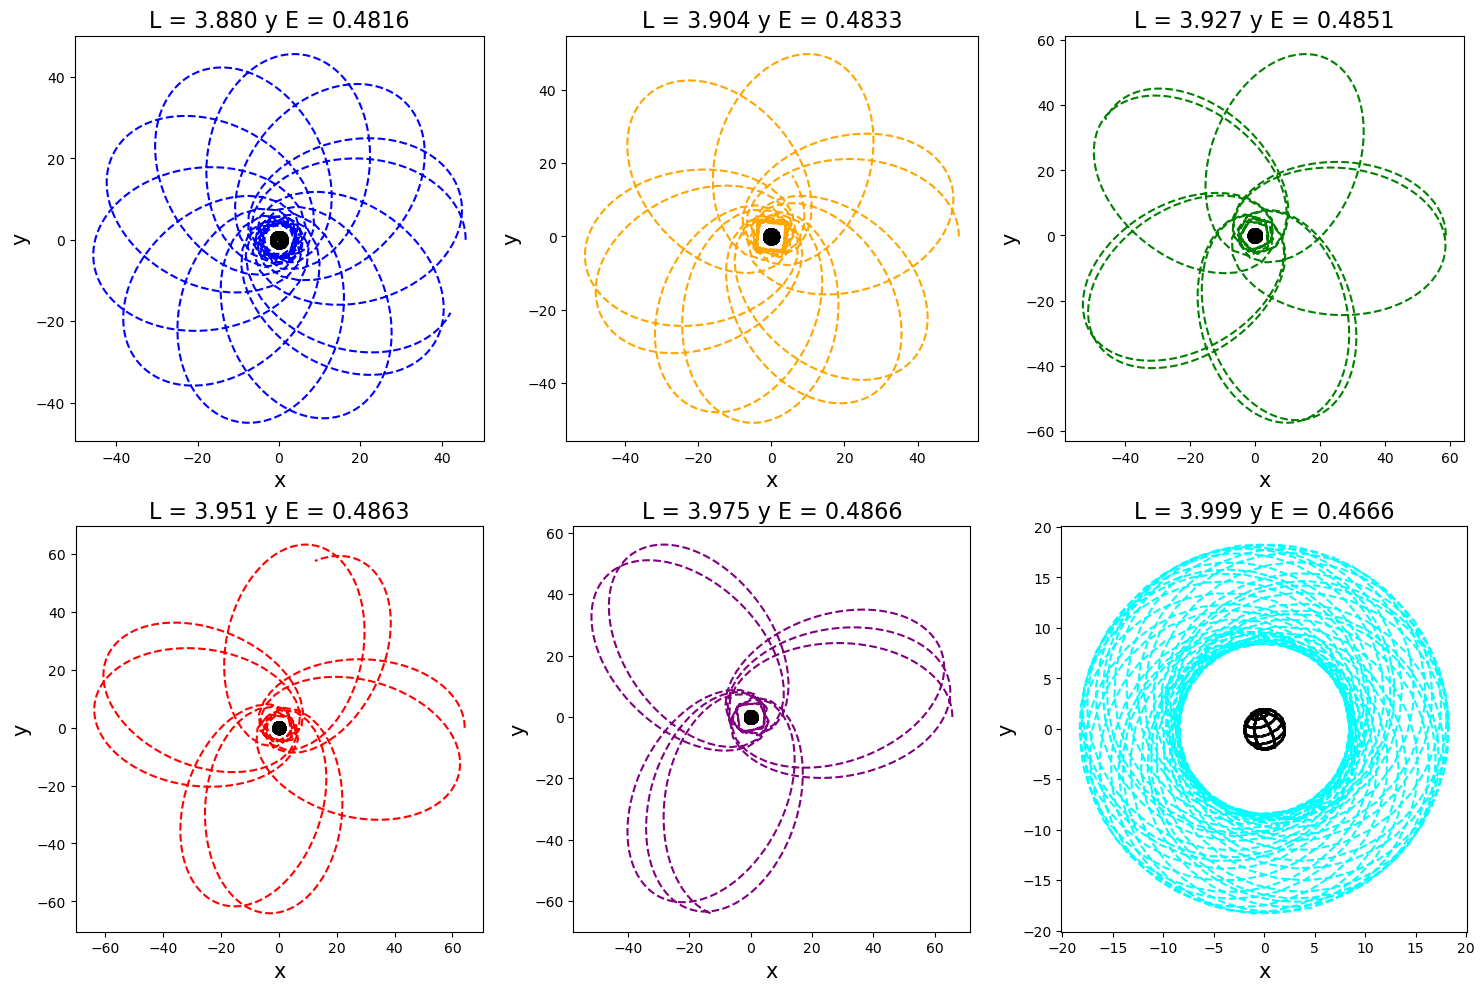

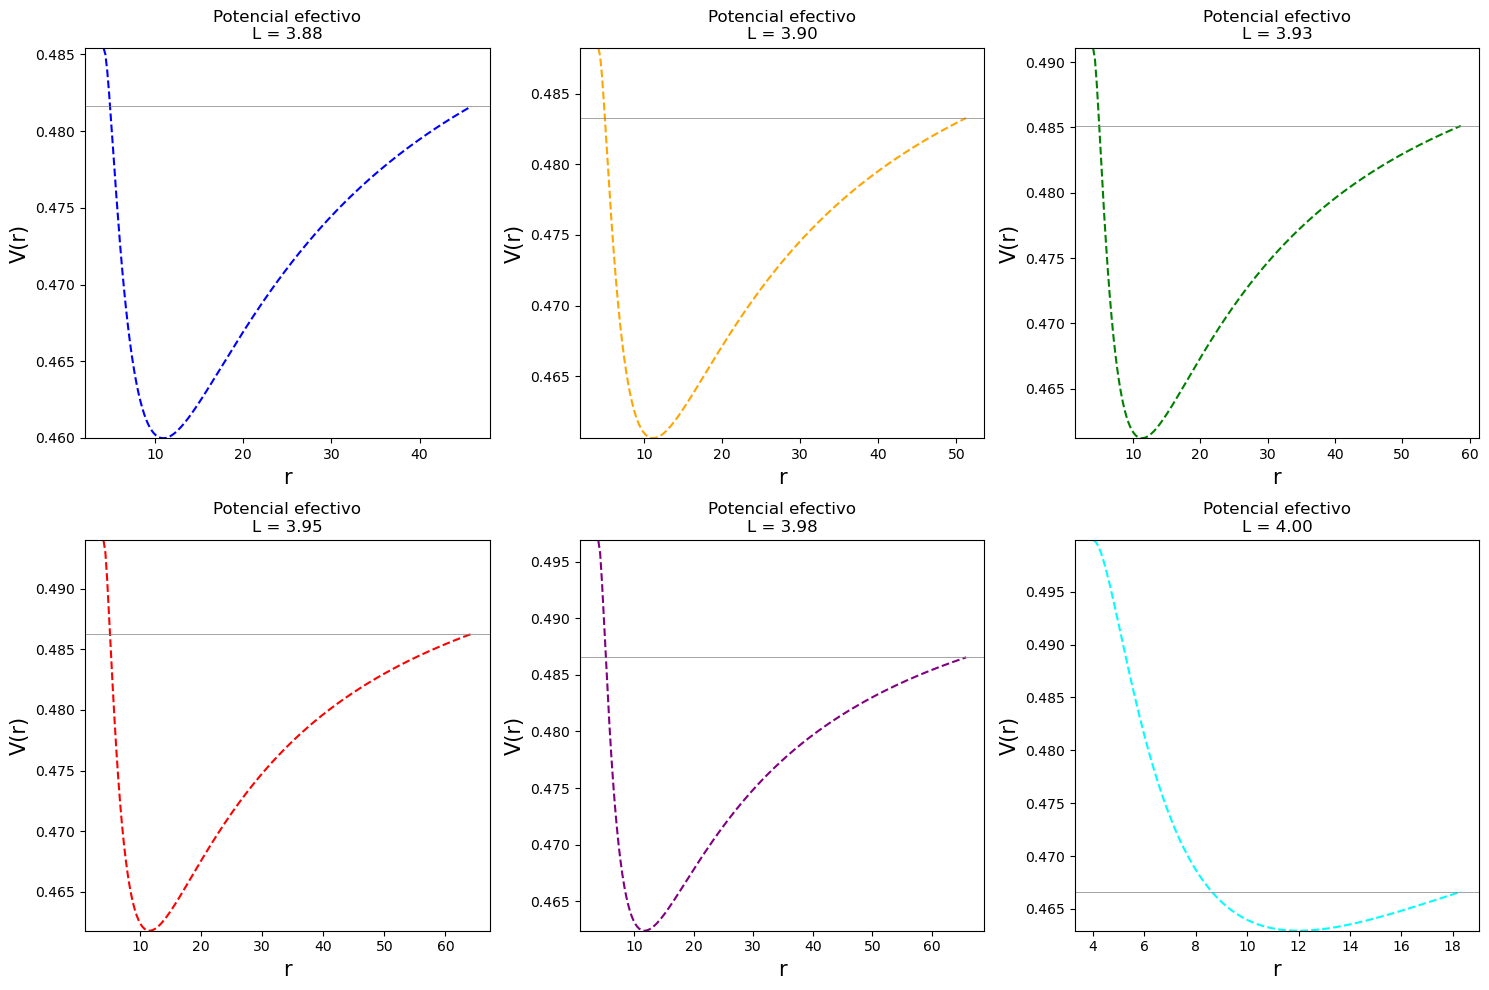

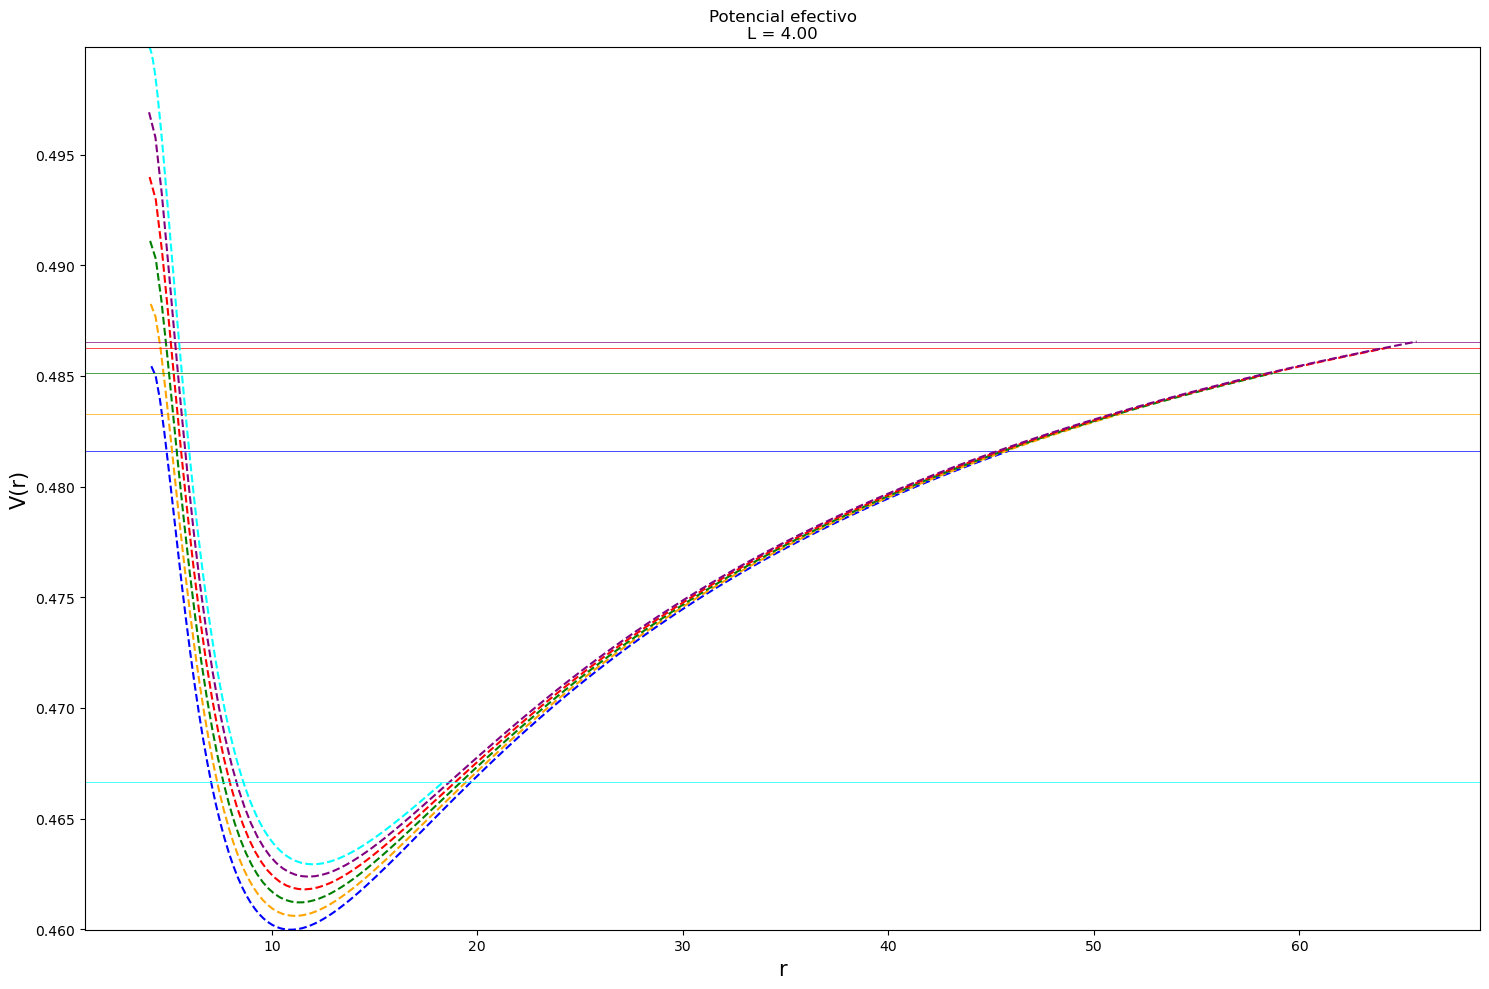

In [178]:


# ----------
# Plots
# ---------

L_mass = 2 * M * np.sqrt(3) * (1.12)
L_list = [2 * M, L_mass, 3.9, 4.1, 5, 10]
#L_list = np.linspace(2 * M, L_mass, 6)
L_list = np.linspace(L_mass, 3.999, 6)
#L_list = np.linspace(4.01, 10, 6)
colors = ["red", "blue", "green", "olive", "pink", "cyan"]
colors = ["blue", "orange", "green", "red", "purple",  "cyan", "olive", "pink"]

ncols = len(L_list) // 2
nrows = 2  # Ya que son 6 elementos

fig1, axes1 = plt.subplots(nrows, ncols, figsize=(5 * ncols, 10))
fig2, axes2 = plt.subplots(nrows, ncols, figsize=(5 * ncols, 10))
fig3, ax = plt.subplots(1, 1, figsize=(5 * ncols, 10))
from Proyección_esfera import EsferaProyectada
with tqdm(total=len(L_list), desc="Renderizando", unit="Tr") as pbar:
    for i, L in enumerate(L_list):
        row = i // ncols
        col = i % ncols
        ax1 = axes1[row, col]
        ax2 = axes2[row, col]
        color = colors[i]

        if (L_mass> 2 * M * np.sqrt(3)) and (L_mass< 2 * 2 * M): 
            h=[0.15, 0.18, 0.2, 0.24, 0.3, 0.9]
            x_massive, y_massive, estilo, r_max, r_min, E_mass = orbitas_masa(L, h[i])
        else:
            x_massive, y_massive, estilo, r_max, r_min, E_mass = orbitas_masa(L)

        ax1.plot(x_massive, y_massive, estilo, color=color, label=f'E = {E_mass:.2f}')

        #ax1.Circle((0,0), 2*M, color="white", fill=True, zorder=100)
        esfera = EsferaProyectada(radius=2 *M)
        proy = esfera.proyectar()
        ax1.scatter(proy[:, 0], proy[:, 1], s=1, color='black', zorder=2)
        #phi_circle = np.linspace(-np.pi, np.pi, 100)
        #ax1.plot( 3 / 2 * rs * np.cos(phi_circle), 3 / 2 * rs * np.sin(phi_circle), color='black', zorder=2)

        #ax1.scatter(0, 0, color='black', s=100) #, label='BH'
        ax1.set_title(f"L = {L:.3f} y E = {E_mass:.4f}", size=16)
        ax1.set_xlabel("x", size=15)
        ax1.set_ylabel("y", size=15)
        ax1.set_aspect("equal")
        #ax1.legend()

        r_vals = np.linspace(r_min, r_max, 200)
        ax.plot(r_vals, V_timelike_geom_units(L, r_vals), estilo, color=color)
        ax2.plot(r_vals, V_timelike_geom_units(L, r_vals), estilo, color=color)
        ax2.axhline(E_mass, color='gray', lw=0.5, label=f"E = {E_mass:.2f}")
        ax.axhline(E_mass, color=color, lw=0.5, label=f"E = {E_mass:.2f}")
        if estilo=="--":
            ax2.set_ylim(V_r_c(L, r_plus(L)), V_r_c(L, r_minus(L)))
            ax.set_ylim(V_r_c(L_list[0], r_plus(L_list[0])), V_r_c(L_list[-1], r_minus(L_list[-1])))
        elif estilo=="-":
            ax2.set_ylim(V_timelike_geom_units(L, r_plus(L)), V_timelike_geom_units(L, r_min)*1.2)
        ax2.set_title(f"Potencial efectivo\nL = {L:.2f}")
        ax2.set_xlabel("r", size=15)
        ax2.set_ylabel("V(r)", size=15)
        ax.set_title(f"Potencial efectivo\nL = {L:.2f}")
        ax.set_xlabel("r", size=15)
        ax.set_ylabel("V(r)", size=15)
        #ax2.legend()
        pbar.update(1)

fig1.tight_layout()
fig2.tight_layout()
fig3.tight_layout()

fig1.savefig("../../Figuras/Trayectorias_masa.png")
fig2.savefig("../../Figuras/Potencial_masa.png")
fig3.savefig("../../Figuras/Potenciales_masa.png")
plt.show()

plt.close(fig1)
plt.close(fig2)
plt.close(fig3)

In [179]:
print(r_max, r_min)

18.313784633848847 4.001001001126408


Para estudiar la precesión, partímos de las órbitas newtonianas

En el caso newtoniano, la gravedad la producen fuerzas centrales que resultan en la siguiente ecuación:

$$
\frac{d^2u_n}{d \phi^2}+ u_n =\frac{r_s}{2}\frac{c^2}{L^2},
$$

donde en este caso también $L$ es el momento angular por unidad de masa. 

La solución a esta ecuación diferencial está dada por

$$
u_n=\frac{r_s}{2}\frac{c^2}{L^2}(1+ e \cos (\phi- \phi_0)), \implies r=\frac{L^2}{GM(1+ e \cos (\phi-\phi_0))},
$$

donde a la constante $e$ se le conoce como excentricidad. Cuando $e=0$ estamos en el caso particular de una órbita circular, mientras que cuando $e<1$ tenemos elipses, $e=1$ parábolas y $e>1$ hipérbolas. Esto es, la solución recoge todas las cónicas que ilustramos en a continuación:

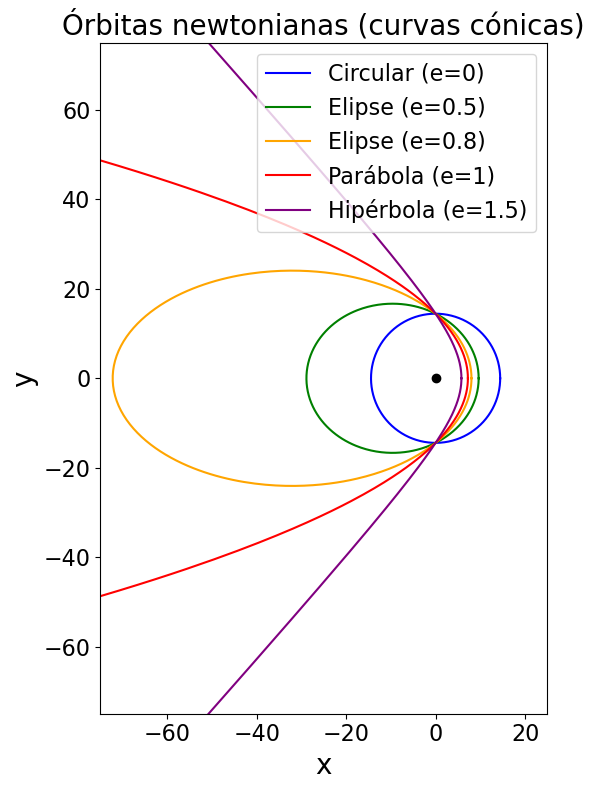

In [132]:

# Constantes físicas arbitrarias
G = 1
M = 1
L = 3.8

# Ángulos evitando singularidades (cos(φ) ≈ -1)
phi = np.linspace(0, 2 * np.pi , 400)

# Valores de excentricidad y sus etiquetas
eccentricities = [0.0, 0.5, 0.8, 1.0, 1.5]
labels = [
    "Circular (e=0)",
    "Elipse (e=0.5)",
    "Elipse (e=0.8)",
    "Parábola (e=1)",
    "Hipérbola (e=1.5)"
]
colors = ['blue', 'green', 'orange', 'red', 'purple']

# Crear figura
fig, ax = plt.subplots(figsize=(8, 8))

# Graficar cada tipo de órbita
for e, label, color in zip(eccentricities, labels, colors):
    with np.errstate(divide='ignore', invalid='ignore'):
        r = L**2 / (G * M * (1 + e * np.cos(phi)))
        r = np.where(r > 100, np.nan, r)  # evitar valores muy grandes
        x = r * np.cos(phi)
        y = r * np.sin(phi)
        ax.plot(x, y, label=label, color=color)

# Dibujar el foco/origen
ax.plot(0, 0, 'ko') #, label='Foco (centro de fuerza)'

# Estética del gráfico
ax.set_title("Órbitas newtonianas (curvas cónicas)", fontsize=20)
ax.set_xlabel("x", size=20)
ax.set_ylabel("y", size=20)
ax.set_aspect('equal')
ax.set_xlim(-75, 25)
ax.set_ylim(-75, 75)
#ax.grid(True)
ax.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

#plt.savefig("../../Figuras/Curvas_cónicas.png")

Con todo esto en mente, analizamos la solución relativista como perturbación pequeña ($v$) a la solución original de newton:

$$
    u=u_n+ \frac{r_s}{2}\frac{c^2}{L^2}v,
$$

donde $v \ll 1$.

La a primer orden resulta ser

$$
    \frac{d^2 v}{d\phi^2}+v= 3 \frac{L^2}{c^2} u_n^2,
$$

La cual se resuelve con

$$
    v=\frac{3}{4} r_s^2 \frac{c^2}{L^2}\left[ \left( 1 + \frac{1}{2}e^2\right) + e  (\phi- \phi_0)  \sin  (\phi- \phi_0)  - \frac{1}{6}e^2 \cos (2 (\phi- \phi_0)) \right].
$$

En resumen, la solución de la Ec. es

$$
u=\frac{r_s}{2}\frac{c^2}{L^2}\left\{(1+ e \cos [(1-\alpha)(\phi- \phi_0)])+ \alpha \left[ \left( 1 + \frac{1}{2}e^2\right)  - \frac{1}{6}e^2 \cos (2 (\phi- \phi_0)) \right]\right\},
$$

0.03 <- has to be small
0.03 <- has to be small
0.03 <- has to be small
0.03 <- has to be small


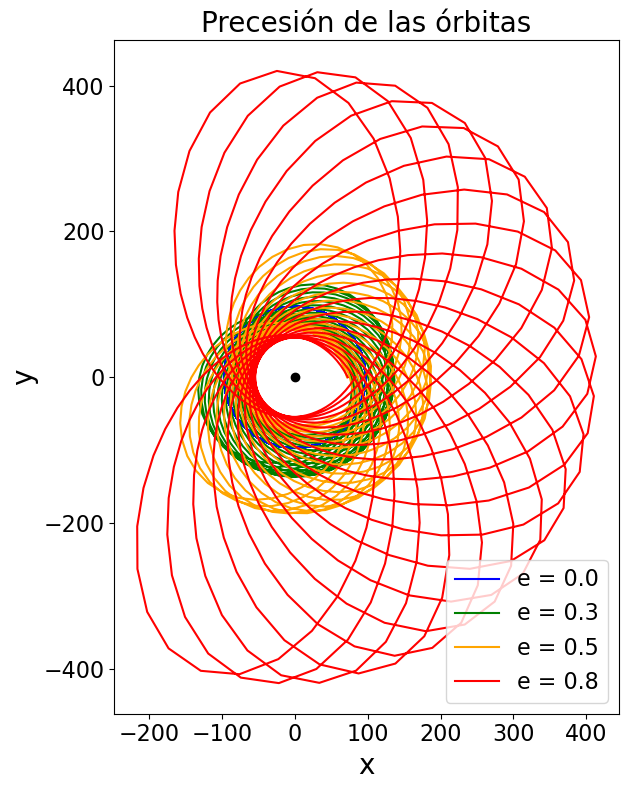

In [145]:
# Constantes físicas arbitrarias
G = 1
M = 1
c = 1
L = 10
rs = 2 * G * M / c**2

# Dominio angular
phi = np.linspace(0.00, 40 * np.pi, 1000)

# Excentricidades a graficar
eccentricities = [0.0, 0.3, 0.5, 0.8]
colors = ['blue', 'green', 'orange', 'red'] 
phi0s=[0, np.pi/8, np.pi/4, 3*np.pi/8]
labels = [f"e = {e}" for e in eccentricities]

# Crear figura
fig, ax = plt.subplots(figsize=(8, 8))

# Bucle sobre cada valor de excentricidad
for e, color, phi0, label in zip(eccentricities, colors, phi0s, labels):
    delta_phi = phi - phi0
    # u = 1/r con corrección relativista
    alpha = (3/4) * rs**2 * (c**2 / L**2) 
    print(alpha, "<- has to be small")
    u = (
        (rs / 2) * (c**2 / L**2) * ((1 + e * np.cos( (1-alpha) * delta_phi)) 
        + alpha * ( (1 + 0.5 * e**2) -(1/6) * e**2 * np.cos(2 * delta_phi)))
    )
    r = 1 / u
    #r = np.where(r > 100, np.nan, r)  # Evita valores extremos
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    ax.plot(x, y, color=color, label=label)

# Dibuja el foco (centro de fuerza)
ax.plot(0, 0, 'ko')

# Estética del gráfico
ax.set_title("Precesión de las órbitas", fontsize=20)
ax.set_xlabel("x", size=20)
ax.set_ylabel("y", size=20)
ax.set_aspect('equal')
#ax.set_xlim(-35, 7.5)
#ax.set_ylim(-20, 20)
#ax.grid(True)
ax.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.savefig("../../Figuras/Orbitas_relativistas_corregidas.png")


Comparemos la solución analítica en el límite con la solución numérica. 

Para ello tenemos que obtener la relación que guardan la escentricidad de la órbita con la energía. Para ello, cogemos la solución newtoniana

$$
u_n=\frac{r_s}{2}\frac{c^2}{L^2}(1+ e \cos (\phi- \phi_0))
$$

Y la introducimos en la siguiente ecuación:

$$
\left( \frac{du}{d \phi}\right)^2=-u^2+ r_su\frac{c^2}{L^2}+\frac{2E- c^2}{L^2}.
$$

Con lo que obtenemos la siguiente relación:

$$
e= \sqrt{1 + 4 L^2 \, \frac{2 E-  c^2}{r_s^2 c^4} } \implies \boxed{E= \frac{c^2}{2}+\frac{r_s^2c^4}{4 L^2}(e^2-1)}
$$

0.03 <- has to be small
500.2497348680157
0.4982


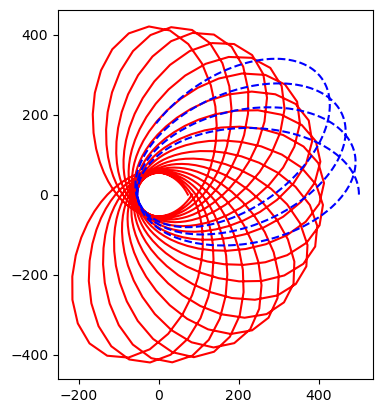

In [176]:
G = 1.0
M = 1.0
c = 1.0
L = 10.0
rs = 2 * G * M / c**2
e=0.8

# Dominio angular
phi = np.linspace(0.00, 40 * np.pi, 1000)

# u = 1/r con corrección relativista
alpha = (3/4) * rs**2 * (c**2 / L**2) 
print(alpha, "<- has to be small")
u = (
    (rs / 2) * (c**2 / L**2) * ((1 + e * np.cos( (1-alpha) * delta_phi)) 
    + alpha * ( (1 + 0.5 * e**2) -(1/6) * e**2 * np.cos(2 * delta_phi)))
)
r = 1 / u
    #r = np.where(r > 100, np.nan, r)  # Evita valores extremos

x = r * np.cos(phi)
y = r * np.sin(phi)

plt.plot(x, y, color="red", label= "Analítico")
plt.gca().set_aspect('equal')
print(r_max)


E_m = (c**2/2+ rs**2*c**4/(8*L**2)*(e**2-1))
print(E_m)
#plt.show()
x_massive, y_massive, estilo, r_max, r_min, E_mass = orbitas_masa(L, E=E_m)
plt.plot(x_massive, y_massive, "--", color="blue", label='RK4')
plt.savefig("../../Figuras/Trayectorias_masa_analitica_vs_numerica.png")


## Soluciones analíticas (no he conseguido que funcione)

Siguiendo la Ref. Darwin 1958


\begin{equation}
    u=u_-+(u_1-u_-) \mathrm{sn}^2 (\xi , k )= \frac{(r_{min}-r_s) - Q}{2 r_s r_{min}}-\left(\frac{Q-r_{min}+3 r_s}{2 r_s r_{min}}\right) \mathrm{sn}^2 (\theta , k  ),
\end{equation}

donde $\mathrm{sn}(x, k)$ es la función elíptica de Jacobi, la inversa de la función elíptica de primera especie y

\begin{equation}
    \theta= \frac{1}{2} \sqrt{\frac{Q}{r_{min}}} (\phi+ \phi_0).
\end{equation}

In [114]:
from scipy.special import ellipk, ellipj, ellipkinc

def orbital_limits(rmin, phi0=0, B=None, M=1.0, E=1.0, G=1, c=1):
    M=M
    E=E
    G=G
    c=c
    rs = 2 * G * M / c**2
    if B is None:
        B = L * c / E

    Q = np.sqrt((rmin - rs) * (rmin + 3 * rs))
    k2 = (Q - rmin + 3 * rs) / (2 * Q)
    k = np.sqrt(k2)

    # Calcular sn^2(ζ1)
    sn2_zeta1 = (rmin - rs - Q) / (rmin - rs + Q)
    sn2_zeta1 = np.clip(sn2_zeta1, 0.0, 1.0)  # Evitar problemas numéricos

    # Invertir sn² -> ζ1 = F(arcsin(sqrt(sn2)), k)
    phi = np.arcsin(np.sqrt(sn2_zeta1))
    zeta1 = ellipkinc(phi, k2)

    # K es la integral completa
    K = ellipk(k2)

    # Compute phi_start and phi_end
    sqrt_factor = 2 * np.sqrt(rmin / Q)
    phi_start = phi0 + sqrt_factor * zeta1
    phi_end = phi0 + sqrt_factor * (2 * K - zeta1)

    return phi_start, phi_end

/var/folders/jx/6bl8lzhn63lb2f8d22k0xl480000gn/T/ipykernel_7849/833123574.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  k2 = (Q - rmin + 3 * rs) / (2 * Q)
/var/folders/jx/6bl8lzhn63lb2f8d22k0xl480000gn/T/ipykernel_7849/833123574.py:17: RuntimeWarning: invalid value encountered in double_scalars
  sn2_zeta1 = (rmin - rs - Q) / (rmin - rs + Q)
/var/folders/jx/6bl8lzhn63lb2f8d22k0xl480000gn/T/ipykernel_7849/833123574.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  sqrt_factor = 2 * np.sqrt(rmin / Q)
/var/folders/jx/6bl8lzhn63lb2f8d22k0xl480000gn/T/ipykernel_7849/3966418180.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  k = np.sqrt((Q - rmin + 3 * rs) / (2 * Q))


Radio mínimo nan 2.0
Radio mínimo nan 2.0
Radio mínimo nan 2.0
Radio mínimo nan 2.0
Radio mínimo -1096377.1931514994 4.453363193811355


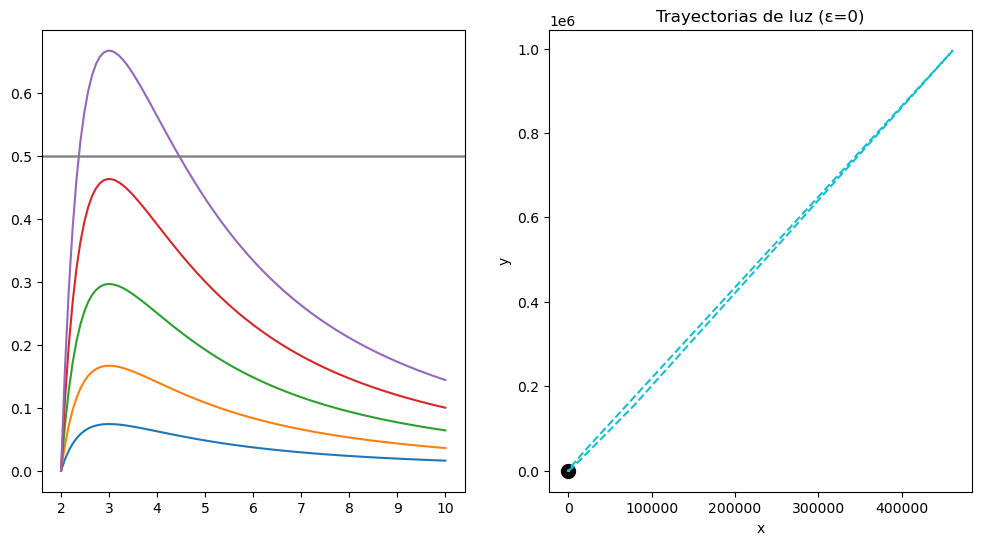

In [119]:

M=1.0
E=1.0
G=1.0
c=1.0
rs = 2 * G * M / c**2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

def V(r, L, M, epsilon):
    return (-0.5 * epsilon +
        epsilon * M +
        L**2 / (2 * r**2) -
        M * L**2 / (r**3))

L_list=[1,2,3,4,5,6]
L_list.sort()

for L in L_list:
    tracer_massless = Orbitas_Schwarzschild(M=M,L=L, E=E, G=G, c=1)
    rmin = tracer_massless.rmin()
    #tracer_massive = SchwarzschildRayTracing(M=M, L=10.0, E=E)

    B=L * c /E

    if rmin < rs:
        continue

    #Analítica
    phi_start, phi_end = orbital_limits(rmin, B=B)
    #print(phi_start, phi_end )
    phi_val=np.linspace(phi_start*1.01, phi_end/1.01, 200)

    r_val = tracer_massless.geodesica(phi_val)

    x_val = r_val * np.cos(phi_val) 
    y_val = r_val * np.sin(phi_val) 
    
    # Resolver trayectorias num
    sol_light = tracer_massless.solve(epsilon=0, max_step=0.1)
    #print(len(sol_light.y[0]))
    #sol_massive = tracer_massive.solve(epsilon=-1, max_step=10)

    # Coordenadas cartesianas
    x_light = sol_light.y[1] * np.cos(sol_light.y[2])
    y_light = sol_light.y[1] * np.sin(sol_light.y[2])

    ax2.plot(x_light, y_light, label='Numérica')
    ax2.plot(x_val,y_val, '--', label='Analítica')

    r= np.linspace(rs, 5*rs, 100)

    ax1.plot(r, tracer_massless.V(r, 0))

    ax1.axhline(E**2/2, color='gray', lw=1)

    rm_rk45 = np.min(sol_light.y[1])
    rm_num= tracer_massless.rmin()
    rm = np.min(r_val)

    print("Radio mínimo", rm,rm_num)


ax2.scatter(0, 0, color='black', s=100, label='BH')
ax2.set_title("Trayectorias de luz (ε=0)")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

#plt.show()
plt.savefig("../../Figuras/Trayectorias_analíticas_luz.png")